In [2]:
library(pheatmap)  
library(tidyverse)
library(RColorBrewer)
library(viridis)
library(reshape2)
library( org.Hs.eg.db ) 
library(AnnotationDbi) 
library(Biobase)
library(limma)
library(tximport)

library(stringr)

library(Rtsne)
library(caret)  
library(clusterProfiler)
library(pheatmap)
library(ReactomePA)
library(annotate)
library(seqinr)
# library(qlcMatrix)


In [3]:
save_pheatmap_png <- function(x, filename, width=1200, height=1000, res = 200) {
  png(filename, width = width, height = height, res = res)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}

save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}


In [4]:
save_prefix = '../data/processed/fig1/rna/'

# differential expression analysis

In [5]:
# rna_files = as.array(list.files('../data/raw/rna/', pattern=('*/*.genes.results'),recursive=TRUE))
# # data.frame(file_path = rna_files)
# tissues = as.array(lapply(rna_files, function(x) strsplit(x, '/')[[1]][1]))
# sample = as.array(lapply(rna_files, function(x) strsplit(x, '/')[[1]][2]))
# sample = as.array(lapply(sample, function(x) strsplit(x, '.genes.results')[[1]][1]))

# full_path = as.array(lapply(rna_files, function(x) paste0('../data/raw/rna/',x)))
                
# rna_genes_result = data.frame("tissues" = tissues,"sample"=sample,"full_path"=full_path )  
# rownames(rna_genes_result) = rna_genes_result$sample        
# head(rna_genes_result  )                          

In [6]:
# files <- file.path(full_path)
# names(files) <- rna_genes_result$sample
# txi.rsem <- tximport(files, type = "rsem", txIn = FALSE, txOut = FALSE)
### ERROR Need to make all rownames the same...

In [7]:

createSig <- function (data, metadata, col_sel,tissue=TRUE, logFC_thres=.1, p_thres=0.05,max_return = 500) {
    # Differential expression analysis with limmma
    # This function takes in a target
    # Output is a result table of differential expression analysis for target vs control

    # load data and preprocess
#     metadata_sel <- labels_df %>% 
#         filter(control==control_id)%>%
#         filter(label == target | label == "control")%>%
#         dplyr::select(-control)    
#     rownames(metadata_sel) = metadata_sel$sample
#     data <- counts_all_filt[ ,rownames(metadata_sel) ]
#     log_data <- log2(data+1) 
    
#     metadata = data.frame("column" =cols_all)
    if (tissue){
    metadata = metadata %>% 
        mutate(label = if_else(tissue==col_sel, 'target', 'control'))
    }
    else{
         metadata = metadata %>% 
        mutate(label = if_else(group==col_sel, 'target', 'control'))
    }

    # set up the design
    labels <- factor(metadata$label)
    design <- model.matrix(~ labels + 1)
    colnames(design) <- levels(labels)
    rownames(design) <- metadata$tissue

    # proceed with analysis
    fit <- lmFit(data, design)
    fit <- eBayes(fit, trend=TRUE)
    tT = topTable(fit, coef=ncol(design),adjust="fdr", sort.by="p", number=Inf)
    tT$gene = rownames(tT)
    tT = na.omit(tT)
    tT_filt = tT[tT$logFC>logFC_thres  & tT$adj.P.Val<p_thres,]
    tT_filt = tT_filt%>% arrange(desc(logFC))
#     print(dim(tT_filt))
    tT_filt = tT_filt[1:min(max_return, dim(tT_filt)[1]),]

  return(tT_filt)
}

In [8]:
rna_tpm_file_tissue = '../data/interim/rna/tissue_tpm_sym.csv'
rna_df_tissue = read.csv(rna_tpm_file_tissue, row.names=1,stringsAsFactors=F,check.names = FALSE)
rna_df_tissue_log = log2(rna_df_tissue+1e-2)
rna_df_tissue_log_bin = rna_df_tissue_log
rna_df_tissue_log_bin[rna_df_tissue_log<0] = 0
rna_df_tissue_log_bin[rna_df_tissue_log>0] = 1

rna_df_tissue_norm = as.data.frame(scale(rna_df_tissue_log, center = TRUE, scale = TRUE))


In [9]:
dim(rna_df_tissue_log_bin)

[1] 23686     9

In [10]:
rna_tpm_file = '../data/interim/rna/sample_tpm_sym.csv'
rna_df = read.csv(rna_tpm_file, row.names=1,stringsAsFactors=F,check.names = FALSE)
rna_df$SL6d_3 = as.numeric(rna_df$SL6d_3)
rna_df[is.na(rna_df)] = 0
rna_df_log = log2(rna_df+1e-2)
rna_df_norm = as.data.frame(scale(rna_df_log, center = TRUE, scale = TRUE))
head(rna_df_norm)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


,H9_1,H9_2,SL6d_1,SL6d_2,SL6d_3,SLC6d_1,SLC6d_2,SLC6d_3,H9_Ngn2_2d_1,H9_Ngn2_2d_2,⋯,H9_28d_BGI_2,SL_Ctrl_28d_1,SL_Ctrl_28d_2,SL_Ctrl_28d_3,SLC_Ctrl_28d_1,SLC_Ctrl_28d_2,SLC_Ctrl_28d_3,H9_D10,Astrocytes-B1,Astrocytes-B2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,0.71980427,0.69702837,0.5908718,0.5190007,0.4585641,0.65064852,0.47607803,0.61385418,0.58004889,0.51506578,⋯,0.3971052,0.6134708,0.6632960,0.7767851,0.8055012,0.7432605,0.4601271,0.3103125,1.15272829,1.1917077
A1BG-AS1,-0.02473896,-0.07652869,0.1937334,0.1907880,0.1177800,0.03679224,0.18454663,0.23426466,0.24410679,0.14589580,⋯,0.4140996,0.2392187,0.4018900,0.1412392,0.0634544,-1.3321773,-1.3028043,0.1764024,-0.05327529,0.1642570
A1CF,-1.37083210,-1.36461056,-1.1323639,-1.0332867,-1.3410674,-1.27369594,-1.33266992,-0.91451258,-1.42700788,-1.20274582,⋯,-0.4353012,-0.8127226,-1.2214491,-1.2585293,-1.3400098,-1.3321773,-1.3028043,-0.7748378,-0.84636801,-0.8286578
A2M,-1.05039963,-1.04523320,-1.3323980,-0.6347573,-1.0279158,-1.27369594,-0.77055770,-0.23812928,0.33296799,0.79867970,⋯,0.2675554,0.1723893,0.3352333,0.4508576,0.3862957,0.3727649,0.7324989,0.2121921,1.54217705,1.3439521
A2M-AS1,-0.39892733,-0.36631682,0.2832405,0.2358768,0.2547225,-0.06838370,0.07562121,0.03087333,-0.17786008,-0.22277500,⋯,0.5310835,0.4094970,0.1778248,0.1881782,0.3869328,0.3769540,0.2668206,0.3140893,-0.57801866,-0.3259786
A2ML1,0.48406611,0.39683593,-0.5921839,-0.6347573,-0.7863997,-1.27369594,-1.01531539,-1.31328617,0.01993072,-0.07643527,⋯,-1.3141899,-1.3078613,-1.2214491,-1.2585293,-1.3400098,-1.3321773,-1.3028043,-0.9293998,-0.47947777,-0.5047099


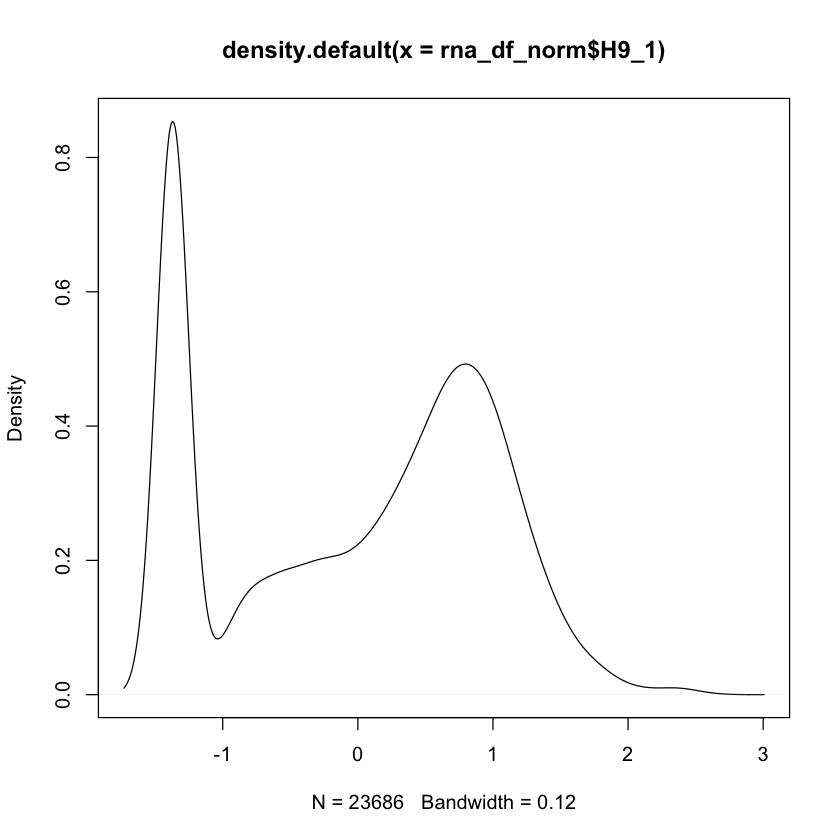

In [11]:
par (bg='white')
plot(density(rna_df_norm$"H9_1"))

In [12]:
rna_results = data.frame(sample=colnames(rna_df_log))
rna_results$sample = as.character(rna_results$sample)
rna_results$tissue = c('H9_D0','H9_D0','SL_D0','SL_D0','SL_D0','SLC_D0','SLC_D0','SLC_D0','H9_D2','H9_D2','H9_D2',
                      'SL_D2','SL_D2','SL_D2','SLC_D2','SLC_D2','SLC_D2','H9_D28','H9_D28','SL_D28','SL_D28','SL_D28','SLC_D28','SLC_D28','SLC_D28',
                      'H9_D10','Astrocytes','Astrocytes')
rna_results

sample,tissue
<chr>,<chr>
H9_1,H9_D0
H9_2,H9_D0
SL6d_1,SL_D0
SL6d_2,SL_D0
SL6d_3,SL_D0
SLC6d_1,SLC_D0
SLC6d_2,SLC_D0
SLC6d_3,SLC_D0
H9_Ngn2_2d_1,H9_D2


In [13]:
paste0(save_prefix,'rna_results.csv')

[1] "../data/processed/fig1/rna/rna_results.csv"

In [14]:
write.csv(rna_results, paste0(save_prefix,'rna_results.csv'))

In [268]:

all_tissue_order = c('Astrocytes','SL_D0','SL_D2','SLC_D0', 'SLC_D2','H9_D0','H9_D2', 'H9_D10','H9_D28')
time_tissue_order = c('H9_D0','H9_D2', 'H9_D10','H9_D28')
time2_tissue_order = c('H9_D0','H9_D2', 'H9_D10')

type0_tissue_order = c('Astrocytes','SL_D0', 'SLC_D0', 'H9_D0')
type1_tissue_order = c('Astrocytes','SL_D2', 'SLC_D2', 'H9_D2')


#

In [269]:
rna_results_sel = rna_results[rna_results$tissue %in% tissues,]
sel_samples = as.array(rna_results_sel$sample)
sel_samples

[1] "H9_1"          "H9_2"          "SL6d_1"        "SL6d_2"       
 [5] "SL6d_3"        "SLC6d_1"       "SLC6d_2"       "SLC6d_3"      
 [9] "Astrocytes-B1" "Astrocytes-B2"

# just base on binarization


In [270]:
 tissues = time_tissue_order
suffix = 'H9_time'

 tissues = time2_tissue_order
suffix = 'H9_time_short'


# tissues = type0_tissue_order
# suffix = 'type_d0'
# tissues = type1_tissue_order
# suffix = 'type_d2'

In [271]:
rna_tpm_file_tissue = '../data/interim/rna/tissue_tpm_sym.csv'
rna_df_tissue = read.csv(rna_tpm_file_tissue, row.names=1,stringsAsFactors=F,check.names = FALSE)
rna_df_tissue_log = log2(rna_df_tissue+1e-2)
rna_df_tissue_log_bin = rna_df_tissue_log
rna_df_tissue_log_bin[rna_df_tissue_log<0] = 0
rna_df_tissue_log_bin[rna_df_tissue_log>0] = 1

rna_df_tissue_norm = as.data.frame(scale(rna_df_tissue_log, center = TRUE, scale = TRUE))

### select tissues
rna_df_tissue_log = rna_df_tissue_log[,tissues]

rna_df_tissue_log_bin = rna_df_tissue_log_bin[,tissues]
rna_df_tissue_norm = rna_df_tissue_norm[,tissues]

In [272]:
all_expressed = rownames(rna_df_tissue_log_bin)[rowSums(rna_df_tissue_log_bin)==dim(rna_df_tissue_log_bin)[2]]
length(all_expressed)
unique_expressed = rownames(rna_df_tissue_log_bin)[rowSums(rna_df_tissue_log_bin)==1]
length(unique_expressed)

[1] 12445

[1] 1632

In [273]:
colnames(rna_df_tissue_log_bin)

[1] "H9_D0"  "H9_D2"  "H9_D10"

In [274]:
# rna_df_tissue_log_bin_unique = rna_df_tissue_log_bin[unique_expressed,]
# unique_Astro = rownames(rna_df_tissue_log_bin_unique)[rownames(rna_df_tissue_log_bin_unique[,'Astrocytes']==1) ]#& (rowSums(rna_df_tissue_log_bin)==1) ]
# unique_SLD0 = rownames(rna_df_tissue_log_bin_unique)[(rna_df_tissue_log_bin_unique[,'SL_D0']==1) ]#& (rowSums(rna_df_tissue_log_bin)==1) 
# unique_SLD2 = rownames(rna_df_tissue_log_bin_unique)[(rna_df_tissue_log_bin_unique[,'SL_D2']==1) ]#& (rowSums(rna_df_tissue_log_bin)==1) 
# unique_SLCD0 = rownames(rna_df_tissue_log_bin_unique)[(rna_df_tissue_log_bin_unique[,'SLC_D0']==1)]# & (rowSums(rna_df_tissue_log_bin)==1) 
# unique_SLCD2 = rownames(rna_df_tissue_log_bin_unique)[(rna_df_tissue_log_bin_unique[,'SLC_D2']==1) ]#& (rowSums(rna_df_tissue_log_bin)==1) 
# unique_H9D0 = rownames(rna_df_tissue_log_bin_unique)[(rna_df_tissue_log_bin_unique[,'H9_D0']==1) ]#& (rowSums(rna_df_tissue_log_bin)==1) 
# unique_H9D2 = rownames(rna_df_tissue_log_bin_unique)[(rna_df_tissue_log_bin_unique[,'H9_D2']==1)  ]#&(rowSums(rna_df_tissue_log_bin)==1) 
# unique_H9D10 = rownames(rna_df_tissue_log_bin_unique)[(rna_df_tissue_log_bin_unique[,'H9_D10']==1)]# & (rowSums(rna_df_tissue_log_bin)==1) 
# unique_H9D28 = rownames(rna_df_tissue_log_bin_unique)[(rna_df_tissue_log_bin_unique[,'H9_D28']==1) ]#& (rowSums(rna_df_tissue_log_bin)==1) 
# unique_combined = c(unique_Astro,unique_SLD0,unique_SLD2,unique_SLCD0,unique_SLCD2,unique_H9D0,unique_H9D2,unique_H9D10,unique_H9D28)
# unique_combined = c(unique_SLD0,unique_SLD2,unique_SLCD0,unique_SLCD2,unique_H9D0,unique_H9D2,unique_H9D10,unique_H9D28)
# unique_combined = rownames(rna_df_tissue_log_bin_unique)[rowSums(rna_df_tissue_log_bin_unique)==1])
# length(unique_combined)

In [275]:
# pheatmap(rna_df_tissue_log[all_expressed,])

In [276]:
rna_df_tissue_norm_manual = rna_df_tissue_log[unique_expressed,tissues]
dim(rna_df_tissue_norm_manual)
rna_df_tissue_norm_manual[rna_df_tissue_norm_manual>2] = 2
rna_df_tissue_norm_manual[rna_df_tissue_norm_manual< -2] = -2
rna_df_tissue_norm_manual = rna_df_tissue_norm_manual[apply(rna_df_tissue_norm_manual,1,max)>0 ,]
rna_df_tissue_norm_manual = rna_df_tissue_norm_manual[apply(rna_df_tissue_norm_manual,1,sum)< 10,]
rna_df_tissue_norm_manual = rna_df_tissue_norm_manual[apply(rna_df_tissue_norm_manual,1,sd)>0.1 ,]
# select_genes = rownames(rna_df_tissue_norm_manual)
dim(rna_df_tissue_norm_manual)

[1] 1632    3

[1] 1631    3

In [277]:
write.csv(rna_df_tissue_norm_manual,  paste0(save_prefix, 'rna_heatmap_unique_',suffix, '.csv'))
write.csv(rna_df_tissue_log_bin[unique_expressed,tissues],  paste0(save_prefix, 'rna_heatmap_unique_bin_',suffix, '.csv'))

[1] "../data/processed/fig1/rna/rna_heatmap_unique_H9_time_short.pdf"

pdf 
  2

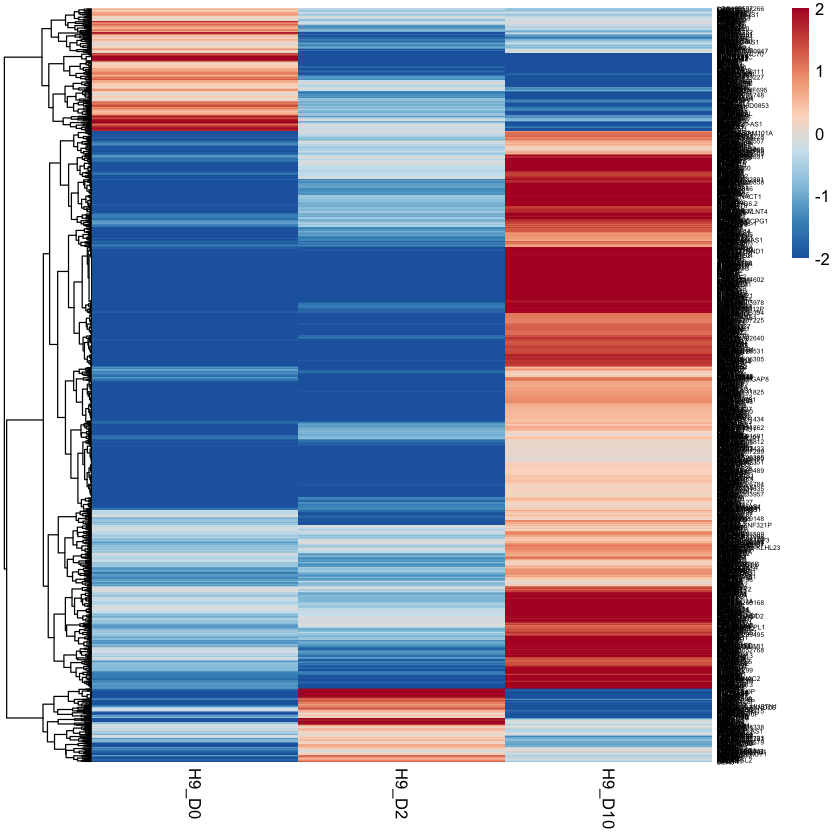

In [305]:
p_with_genes = pheatmap(rna_df_tissue_norm_manual,
             cluster_rows=T,
             cluster_cols=F,
            fontsize_row=4,
#              annotation_col=annon_df,
               color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))

 paste0(save_prefix, 'rna_heatmap_unique_',suffix, '.pdf')
save_pheatmap_pdf(p_with_genes, paste0(save_prefix, 'rna_heatmap_unique_',suffix, '.pdf'), width=10, height=100) 


[1] "../data/processed/fig1/rna/rna_heatmap_unique_no_genes_H9_time_short.pdf"

pdf 
  2

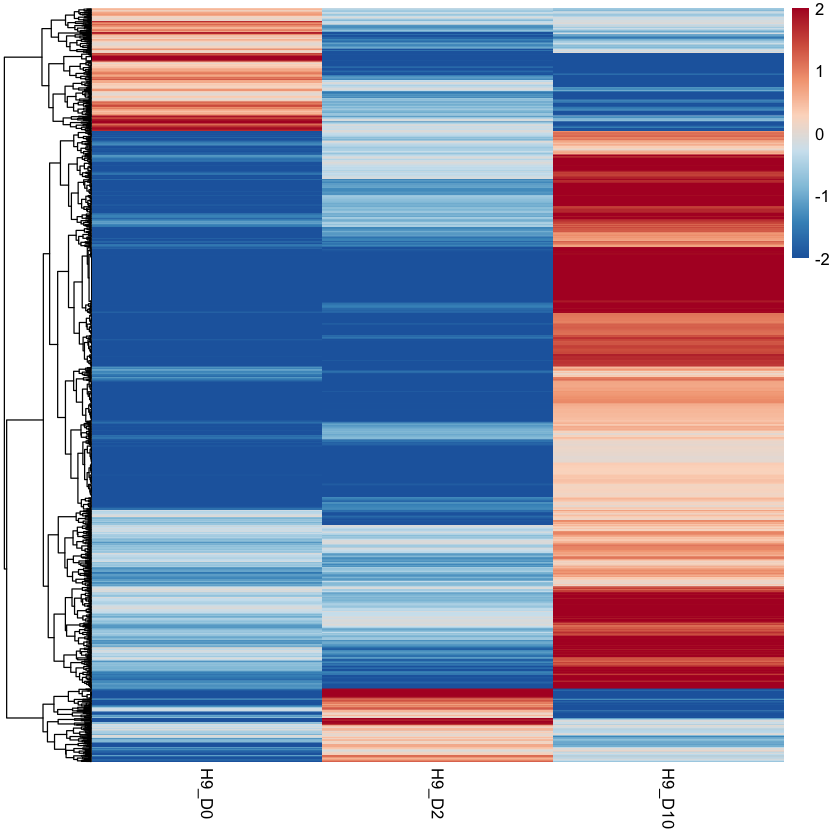

In [306]:
p_no_genes = pheatmap(rna_df_tissue_norm_manual,
             cluster_rows=T,
             cluster_cols=F,
                show_rownames=F,
#              annotation_col=annon_df,
               color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))

paste0(save_prefix, 'rna_heatmap_unique_no_genes_',suffix, '.pdf')
save_pheatmap_pdf(p_no_genes, paste0(save_prefix, 'rna_heatmap_unique_no_genes_',suffix, '.pdf'), width=10, height=10) 


# signifiance method

Not as good

In [280]:
# rna_genes_result_normal$group = c("purple","purple","blue","blue","purple","purple","green","green","green","green",
#                                  "purple","purple","purple","purple","purple","purple",
#                                  "grey","grey","purple","purple","blue","blue",
#                                  "green","green","green","green","purple","purple",
#                                  "green","green","green","green","purple","purple")
# rna_genes_result_normal

In [281]:
rna_sel_df= rna_df_log[,colnames(rna_df_log) %in% sel_samples]

dim(rna_sel_df)
rna_sel_df = na.omit(rna_sel_df)
dim(rna_sel_df)


[1] 23686    10

[1] 23686    10

In [282]:
# #### per group


# sig_genes_list = list()
# sig_genes_combined = c()
# for (group in c("grey","blue","green","purple")){
#     tT_filt = createSig(rna_sel_df, rna_genes_result_normal,  col_sel=group,tissue=FALSE,max_return = 2500)
#     print(group)
#     print(dim(tT_filt))
#     sig_genes_list[[group]] = tT_filt$gene
#     sig_genes_combined = c(sig_genes_combined,tT_filt$gene)
# }

In [283]:
#### per tissue (didn't work)


sig_genes_list = list()
sig_genes_combined = c()
for (tissue_sel in tissues){
    tT_filt = createSig(rna_sel_df, rna_results_sel, tissue_sel,max_return = 1000)
    print(tissue_sel)
    print(dim(tT_filt))
    sig_genes_list[[tissue_sel]] = tT_filt$gene
    sig_genes_combined = c(sig_genes_combined,tT_filt$gene)
}

[1] "H9_D0"
[1] 628   7


ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels


In [284]:
length(sig_genes_combined)
# sig_genes_combined = unique(sort(sig_genes_combined))
sig_genes_combined = unique(sig_genes_combined)
length(sig_genes_combined)

[1] 628

[1] 628

### plotting

In [285]:
# annon_df = rna_genes_result_normal%>%
#     dplyr::select( tissues, group)%>%
#     unique()
# rownames(annon_df) = annon_df$tissues
# annon_df = dplyr::select(annon_df, group)
# annon_df

In [286]:
# write.csv(annon_df, '../data/processed/fig1/annon_df.csv')

In [287]:
rna_df_tissue_norm_sig = rna_df_tissue_norm[sig_genes_combined,tissues]
dim(rna_df_tissue_norm_sig)
rna_df_tissue_norm_sig[rna_df_tissue_norm_sig>2] = 2
rna_df_tissue_norm_sig[rna_df_tissue_norm_sig< -2] = -2
rna_df_tissue_norm_sig = rna_df_tissue_norm_sig[apply(rna_df_tissue_norm_sig,1,max)>0 ,]
rna_df_tissue_norm_sig = rna_df_tissue_norm_sig[apply(rna_df_tissue_norm_sig,1,sum)< 7,]
rna_df_tissue_norm_sig = rna_df_tissue_norm_sig[apply(rna_df_tissue_norm_sig,1,sd)>0.2 ,]
select_genes = rownames(rna_df_tissue_norm_sig)
dim(rna_df_tissue_norm_sig)

[1] 628   3

[1] 263   3

In [288]:
# p_with_genes = pheatmap(rna_df_tissue_norm_sig,
#              cluster_rows=T,
#              cluster_cols=T,
#             fontsize=4,
# #              annotation_col=annon_df,
#                color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))

# paste0(save_prefix, 'rna_heatmap_sig_',suffix, '.pdf')
# save_pheatmap_pdf(p_with_genes, paste0(save_prefix, 'rna_heatmap_sig_',suffix, '.pdf'), width=10, height=100) 
# # save_pheatmap_png(p_with_genes, paste0(save_prefix, 'rna_heatmap.png'), width=1200, height=40000, res = 200) 

In [289]:
# rna_df_tissue_norm_manual = rna_df_tissue_log[unique_combined,tissues]
# dim(rna_df_tissue_norm_manual)
# rna_df_tissue_norm_manual[rna_df_tissue_norm_manual>2] = 2
# rna_df_tissue_norm_manual[rna_df_tissue_norm_manual< -2] = -2
# rna_df_tissue_norm_manual = rna_df_tissue_norm_manual[apply(rna_df_tissue_norm_manual,1,max)>0 ,]
# rna_df_tissue_norm_manual = rna_df_tissue_norm_manual[apply(rna_df_tissue_norm_manual,1,sum)< 7,]
# rna_df_tissue_norm_manual = rna_df_tissue_norm_manual[apply(rna_df_tissue_norm_manual,1,sd)>0.2 ,]
# # select_genes = rownames(rna_df_tissue_norm_manual)
# dim(rna_df_tissue_norm_manual)

In [159]:
# p_no_genes = pheatmap(rna_df_tissue_norm_sig,
#              cluster_rows=F,
#              cluster_cols=F,
#                 show_rownames=F,
#              annotation_col=annon_df,
#                color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))

# save_pheatmap_png(p_no_genes, paste0(save_prefix, 'rna_heatmap_no_genes.png'), width=3000, height=3000, res = 500) 

# getting gene signatures

In [97]:
# purple_genes= sig_genes_list$purple[ sig_genes_list$purple %in% select_genes]
# length(purple_genes)
# green_genes = sig_genes_list$green[ sig_genes_list$green %in% select_genes]
# length(green_genes)
# blue_genes  = sig_genes_list$blue[ sig_genes_list$blue %in% select_genes]
# length(blue_genes)
# grey_genes  = sig_genes_list$grey[ sig_genes_list$grey %in% select_genes]
# length(grey_genes)
# all_genes = rownames(rna_df_tissue_norm)
# length(all_genes)

In [98]:
# library(VennDiagram)
 
# # Chart
# venn.diagram(
#   x = list(purple_genes, green_genes, blue_genes,grey_genes),
#   category.names = c("purple", "green", "blue", "grey"),
#   filename = paste0(save_prefix,'venn_diagram.svg'),
# #   output=TRUE
#  # Output features
#     imagetype="svg" ,
#     height = 480 , 
#     width = 480 , 
#     resolution = 300,
#     compression = "lzw",

#     # Circles
#     lwd = 2,
#     lty = 'blank',
#     fill = c("purple","green", "blue", "grey"),
#  )       

In [101]:
# write.table(sort(rownames(rna_df)), file = paste0(save_prefix, "all_genes.csv"),row.names=FALSE,col.names=FALSE)

# write.table(sort(all_expressed), file = paste0(save_prefix, "all_expressed_genes.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(unique_SLD0), file = paste0(save_prefix, "unique_SLD0.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(unique_SLD2), file = paste0(save_prefix, "unique_SLD2.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(unique_SLCD0), file = paste0(save_prefix, "unique_SLCD0.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(unique_SLCD2), file = paste0(save_prefix, "unique_SLCD2.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(unique_H9D0), file = paste0(save_prefix, "unique_H9D0.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(unique_H9D2), file = paste0(save_prefix, "unique_H9D2.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(unique_H9D10), file = paste0(save_prefix, "unique_H9D10.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(unique_H9D28), file = paste0(save_prefix, "unique_H9D28.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(unique_combined), file = paste0(save_prefix, "unique_combined_genes.csv"),row.names=FALSE,col.names=FALSE)


# getting gene signatures

In [307]:
# tissues = time_tissue_order
suffix = 'H9_time'

# # tissues = time2_tissue_order
# suffix = 'H9_time_short'

# tissues = type0_tissue_order
# suffix = 'type_d0'

# tissues = type1_tissue_order
# suffix = 'type_d2'



paste0(save_prefix, 'rna_heatmap_unique_bin_',suffix, '.csv')

rna_df_tissue_log_bin = read.csv(paste0(save_prefix, 'rna_heatmap_unique_bin_',suffix, '.csv'),row.names=1)
head(rna_df_tissue_log_bin)

dim(rna_df_tissue_log_bin)


[1] "../data/processed/fig1/rna/rna_heatmap_unique_bin_H9_time.csv"

,H9_D0,H9_D2,H9_D10,H9_D28
,<int>,<int>,<int>,<int>
ABCA12,0,0,1,0
ABCA4,0,0,1,0
ABCB4,0,0,1,0
ABCC9,0,0,0,1
ABCD2,0,0,0,1
ABI3BP,0,0,1,0


[1] 1397    4

In [310]:
cluster_all = list()
for (tissue in colnames(rna_df_tissue_log_bin)){
    print(tissue)
    unique_tissue = rownames(rna_df_tissue_log_bin)[rna_df_tissue_log_bin[[tissue]]==1]
    write.table(sort(unique_tissue), paste0(save_prefix,'rna_genes_',suffix,'_',tissue,'.csv'),row.names=FALSE,col.names=FALSE)
    print(length(unique_tissue))
    unique_entrez = bitr(unique_tissue, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
    print(length(unique_entrez))
    cluster_all[[tissue]] = unique_entrez

}

[1] "H9_D0"
[1] 210


'select()' returned 1:many mapping between keys and columns

Warning message in bitr(unique_tissue, fromType = "SYMBOL", toType = "ENTREZID", :
“11.43% of input gene IDs are fail to map...”


[1] 187
[1] "H9_D2"
[1] 101


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(unique_tissue, fromType = "SYMBOL", toType = "ENTREZID", :
“12.87% of input gene IDs are fail to map...”


[1] 88
[1] "H9_D10"
[1] 449


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(unique_tissue, fromType = "SYMBOL", toType = "ENTREZID", :
“11.14% of input gene IDs are fail to map...”


[1] 399
[1] "H9_D28"
[1] 637


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(unique_tissue, fromType = "SYMBOL", toType = "ENTREZID", :
“15.07% of input gene IDs are fail to map...”


[1] 541


In [294]:
# unique_SLD0 = read.table(file = paste0(save_prefix, "unique_SLD0.csv"))$V1
# unique_SLD2 = read.table(file = paste0(save_prefix, "unique_SLD2.csv"))$V1
# unique_SLCD0 = read.table(file = paste0(save_prefix, "unique_SLD0.csv"))$V1
# unique_SLCD2 = read.table(file = paste0(save_prefix, "unique_SLCD2.csv"))$V1
# unique_H9D0 = read.table(file = paste0(save_prefix, "unique_H9D0.csv"))$V1
# unique_H9D2 = read.table(file = paste0(save_prefix, "unique_H9D2.csv"))$V1
# unique_H9D10 = read.table(file = paste0(save_prefix, "unique_H9D10.csv"))$V1
# unique_H9D28 = read.table(file = paste0(save_prefix, "unique_H9D28.csv"))$V1

all_genes = read.table(file = paste0(save_prefix, "all_genes.csv"))$V1
length(all_genes)
all_entrez = bitr(all_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
length(all_entrez)

[1] 23686

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(all_genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“9.32% of input gene IDs are fail to map...”


[1] 21482

In [295]:
# unique_SLD0_entrez = bitr(unique_SLD0, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
# unique_SLD2_entrez = bitr(unique_SLD2, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
# unique_SLCD0_entrez = bitr(unique_SLCD0, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
# unique_SLCD2_entrez = bitr(unique_SLCD2, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
# unique_H9D0_entrez = bitr(unique_H9D0, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
# unique_H9D2_entrez = bitr(unique_H9D2, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
# unique_H9D10_entrez = bitr(unique_H9D10, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
# unique_H9D28_entrez = bitr(unique_H9D28, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID



In [296]:
# length(unique_SLD0_entrez)
# length(unique_SLD2_entrez)
# length(unique_SLCD0_entrez)
# length(unique_SLCD2_entrez)
# length(unique_H9D0_entrez)
# length(unique_H9D2_entrez)
# length(unique_H9D10_entrez)
# length(unique_H9D28_entrez)



In [297]:
# unique_H9D28

In [298]:
# cluster_all <- list(SLD0 = unique_SLD0_entrez, 
#                        SLD2 = unique_SLD2_entrez,
#                       SLCD0 = unique_SLCD0_entrez,
#                       SLCD2 = unique_SLCD2_entrez,
#                     H9D0 = unique_H9D0_entrez,
#                     H9D2 = unique_H9D2_entrez,
#                     H9D10 = unique_H9D10_entrez,
#                     H9D28 = unique_H9D28_entrez
#                    )

In [299]:
ck_reactome_90 <- compareCluster(geneCluster = cluster_all, 
                                 fun = "enrichPathway", pAdjustMethod='none', pvalueCutoff = 1,readable=TRUE)
write.csv(ck_reactome_90, file = paste0(save_prefix, "ck_reactome_groups_",suffix,".csv"))

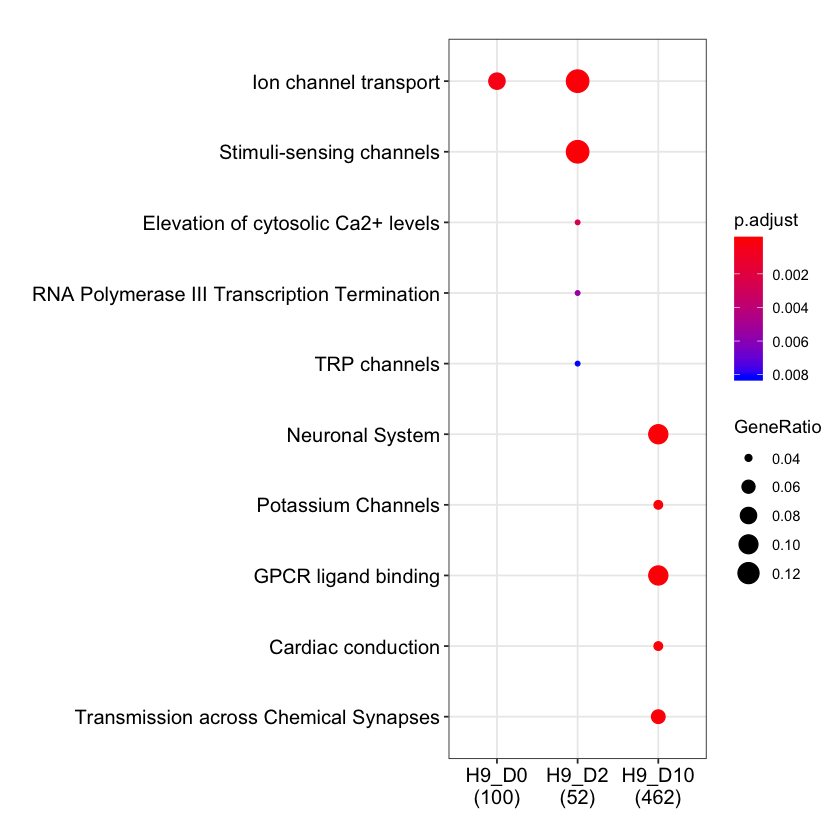

In [300]:
dotplot(ck_reactome_90)
ggsave(file = paste0(save_prefix, "ck_reactome_groups_",suffix,".png"),height=7, width=10)

In [301]:
ck_go_bp <- compareCluster(geneCluster = cluster_all, fun = "enrichGO", 
                                pAdjustMethod='BH', 
                                pvalueCutoff  = 0.05,
                                qvalueCutoff  = 0.05,
                                OrgDb='org.Hs.eg.db', 
                                ont = "BP",
                                readable=TRUE)
head(as.data.frame(ck_go_bp))
write.csv(ck_go_bp, file=paste0(save_prefix, 'ck_go_bp_05_',suffix,".csv"))

ck_go_mf <- compareCluster(geneCluster = cluster_all, fun = "enrichGO", 
                                pAdjustMethod='BH', 
                                pvalueCutoff  = 0.05,
                                qvalueCutoff  = 0.05,
                                OrgDb='org.Hs.eg.db', 
                                ont = "MF",
                                readable=TRUE)                              
head(as.data.frame(ck_go_mf))
write.csv(ck_go_mf, file=paste0(save_prefix, 'ck_go_mf_05_',suffix,".csv"))


ck_go_cc <- compareCluster(geneCluster = cluster_all, fun = "enrichGO", 
                                pAdjustMethod='BH', 
                                pvalueCutoff  = 0.05,
                                qvalueCutoff  = 0.05,
                                OrgDb='org.Hs.eg.db', 
                                ont = "CC",
                                readable=TRUE)
head(as.data.frame(ck_go_cc))
write.csv(ck_go_cc, file=paste0(save_prefix, 'ck_go_cc_05_',suffix,".csv"))

,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,H9_D2,GO:0055074,calcium ion homeostasis,12/102,471/18670,9.992121e-06,1.840549e-02,1.767028e-02,APLNR/CALCA/CAV3/CCL1/CHRNA10/EDN3/FAM20A/GNA15/MCOLN3/P2RX1/PDGFRA/TRPC6,12
2,H9_D2,GO:0051480,regulation of cytosolic calcium ion concentration,10/102,357/18670,2.579530e-05,2.375747e-02,2.280848e-02,APLNR/CALCA/CAV3/CCL1/CHRNA10/GNA15/MCOLN3/P2RX1/PDGFRA/TRPC6,10
3,H9_D2,GO:0006874,cellular calcium ion homeostasis,11/102,458/18670,4.109996e-05,2.523538e-02,2.422735e-02,APLNR/CALCA/CAV3/CCL1/CHRNA10/EDN3/GNA15/MCOLN3/P2RX1/PDGFRA/TRPC6,11
4,H9_D2,GO:0007204,positive regulation of cytosolic calcium ion concentration,9/102,319/18670,6.309509e-05,2.905529e-02,2.789467e-02,APLNR/CALCA/CAV3/CCL1/CHRNA10/GNA15/MCOLN3/PDGFRA/TRPC6,9
5,H9_D2,GO:0072503,cellular divalent inorganic cation homeostasis,11/102,493/18670,7.959939e-05,2.932442e-02,2.815305e-02,APLNR/CALCA/CAV3/CCL1/CHRNA10/EDN3/GNA15/MCOLN3/P2RX1/PDGFRA/TRPC6,11
6,H9_D10,GO:0071804,cellular potassium ion transport,32/812,217/18670,1.391693e-09,2.643095e-06,2.222403e-06,ABCC8/AKAP6/AQP1/CACNA1D/DPP6/FXYD2/KCNA2/KCNA7/KCNAB1/KCNB1/KCNC2/KCND3/KCNE1/KCNH7/KCNIP1/KCNJ14/KCNJ2/KCNJ3/KCNJ5/KCNJ9/KCNK10/KCNK2/KCNK9/KCNN4/KCNQ3/KCNS2/NALCN/OPRK1/SLC12A5/SLC24A5/TREM2/WNK4,32


,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,H9_D2,GO:0015267,channel activity,12/86,456/17697,2.016790e-06,0.0002599484,0.0002334540,ANO2/CACNG5/CHRNA10/CHRNG/CLCNKA/GJC2/KCNG2/MCOLN3/P2RX1/SCNN1B/SCNN1G/TRPC6,12
2,H9_D2,GO:0022803,passive transmembrane transporter activity,12/86,457/17697,2.063082e-06,0.0002599484,0.0002334540,ANO2/CACNG5/CHRNA10/CHRNG/CLCNKA/GJC2/KCNG2/MCOLN3/P2RX1/SCNN1B/SCNN1G/TRPC6,12
3,H9_D2,GO:0022839,ion gated channel activity,10/86,334/17697,4.981879e-06,0.0002932269,0.0002633408,ANO2/CACNG5/CHRNA10/CHRNG/CLCNKA/KCNG2/MCOLN3/P2RX1/SCNN1B/SCNN1G,10
4,H9_D2,GO:0005216,ion channel activity,11/86,416/17697,5.332563e-06,0.0002932269,0.0002633408,ANO2/CACNG5/CHRNA10/CHRNG/CLCNKA/KCNG2/MCOLN3/P2RX1/SCNN1B/SCNN1G/TRPC6,11
5,H9_D2,GO:0022836,gated channel activity,10/86,343/17697,6.295931e-06,0.0002932269,0.0002633408,ANO2/CACNG5/CHRNA10/CHRNG/CLCNKA/KCNG2/MCOLN3/P2RX1/SCNN1B/SCNN1G,10
6,H9_D2,GO:0022838,substrate-specific channel activity,11/86,428/17697,6.981592e-06,0.0002932269,0.0002633408,ANO2/CACNG5/CHRNA10/CHRNG/CLCNKA/KCNG2/MCOLN3/P2RX1/SCNN1B/SCNN1G/TRPC6,11


,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,H9_D2,GO:0034702,ion channel complex,8/103,301/19717,1.821743e-04,2.092521e-02,1.955164e-02,ANO2/CACNG5/CHRNG/CLCNKA/KCNG2/SCNN1B/SCNN1G/TRPC6,8
2,H9_D2,GO:1902495,transmembrane transporter complex,8/103,324/19717,2.996043e-04,2.092521e-02,1.955164e-02,ANO2/CACNG5/CHRNG/CLCNKA/KCNG2/SCNN1B/SCNN1G/TRPC6,8
3,H9_D2,GO:1990351,transporter complex,8/103,332/19717,3.526721e-04,2.092521e-02,1.955164e-02,ANO2/CACNG5/CHRNG/CLCNKA/KCNG2/SCNN1B/SCNN1G/TRPC6,8
4,H9_D10,GO:0034702,ion channel complex,48/865,301/19717,7.038689e-15,1.720084e-12,1.403130e-12,ABCC8/AKAP6/BEST1/BEST3/CACNA1C/CACNA1D/CACNA1E/CACNG3/CATSPER2/CATSPERG/CFTR/CHRNA2/CHRNB3/CNGB1/DPP6/GABRG2/GABRG3/GLRA2/GLRB/GRIA2/GRIK1/GRIN1/GRIN3A/GRIN3B/KCNA2/KCNA7/KCNAB1/KCNB1/KCNC2/KCND3/KCNE1/KCNIP1/KCNJ14/KCNJ2/KCNJ3/KCNJ5/KCNK2/KCNN4/KCNQ3/KCNS2/OLFM3/SCN2A/SCN2B/SCN3A/SCN9A/UNC80/VWC2/VWC2L,48
5,H9_D10,GO:1902495,transmembrane transporter complex,50/865,324/19717,7.303964e-15,1.720084e-12,1.403130e-12,ABCC8/AKAP6/BEST1/BEST3/CACNA1C/CACNA1D/CACNA1E/CACNG3/CATSPER2/CATSPERG/CFTR/CHRNA2/CHRNB3/CNGA3/CNGB1/DPP6/FXYD2/GABRG2/GABRG3/GLRA2/GLRB/GRIA2/GRIK1/GRIN1/GRIN3A/GRIN3B/KCNA2/KCNA7/KCNAB1/KCNB1/KCNC2/KCND3/KCNE1/KCNIP1/KCNJ14/KCNJ2/KCNJ3/KCNJ5/KCNK2/KCNN4/KCNQ3/KCNS2/OLFM3/SCN2A/SCN2B/SCN3A/SCN9A/UNC80/VWC2/VWC2L,50
6,H9_D10,GO:1990351,transporter complex,50/865,332/19717,1.958816e-14,3.075341e-12,2.508659e-12,ABCC8/AKAP6/BEST1/BEST3/CACNA1C/CACNA1D/CACNA1E/CACNG3/CATSPER2/CATSPERG/CFTR/CHRNA2/CHRNB3/CNGA3/CNGB1/DPP6/FXYD2/GABRG2/GABRG3/GLRA2/GLRB/GRIA2/GRIK1/GRIN1/GRIN3A/GRIN3B/KCNA2/KCNA7/KCNAB1/KCNB1/KCNC2/KCND3/KCNE1/KCNIP1/KCNJ14/KCNJ2/KCNJ3/KCNJ5/KCNK2/KCNN4/KCNQ3/KCNS2/OLFM3/SCN2A/SCN2B/SCN3A/SCN9A/UNC80/VWC2/VWC2L,50


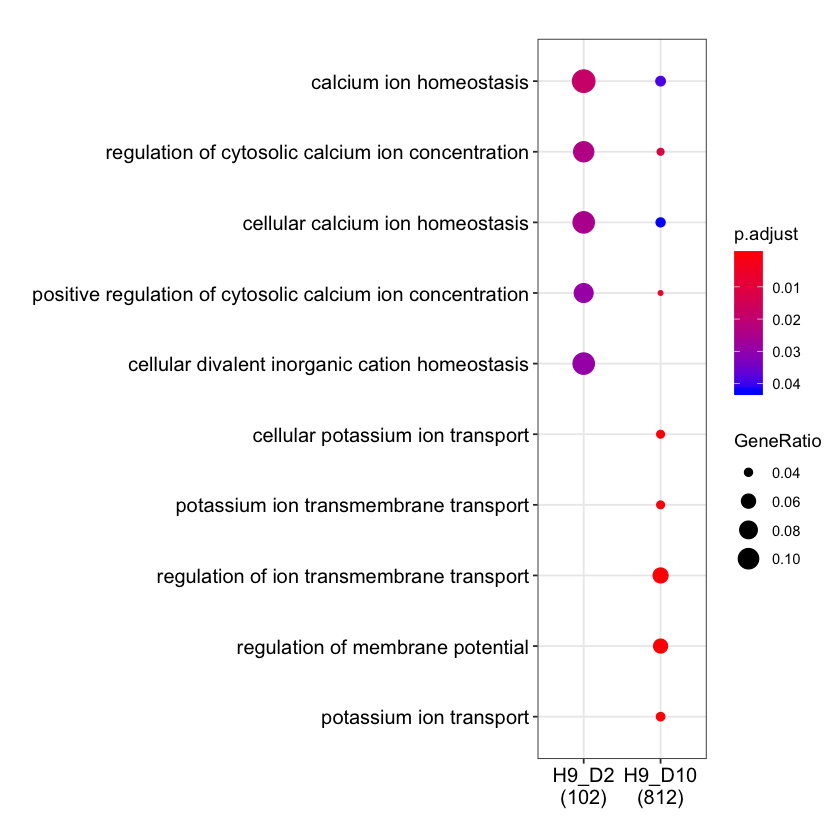

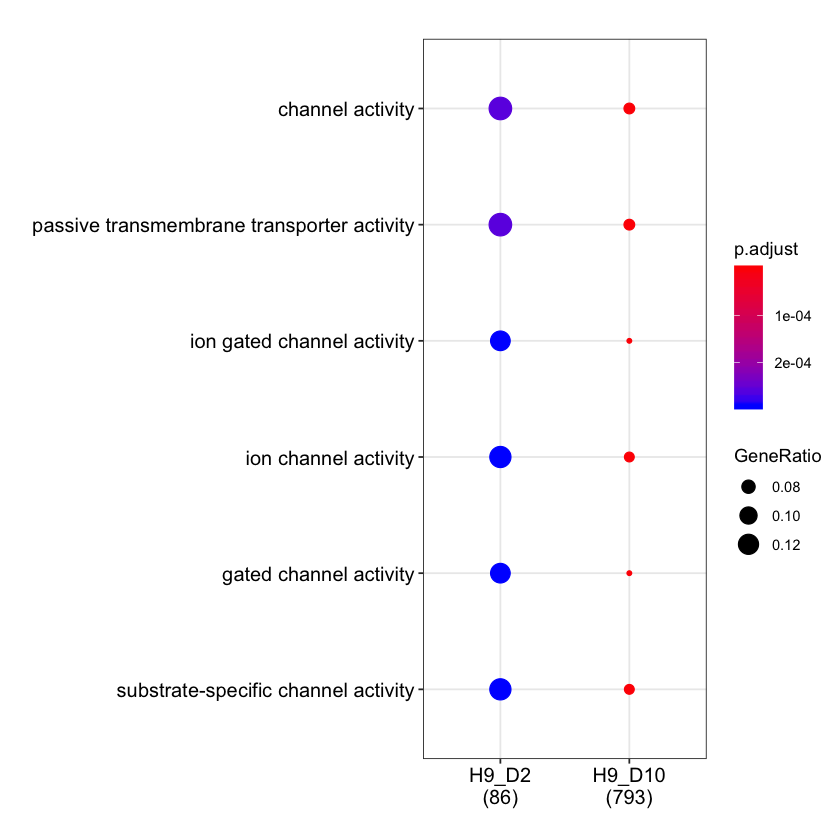

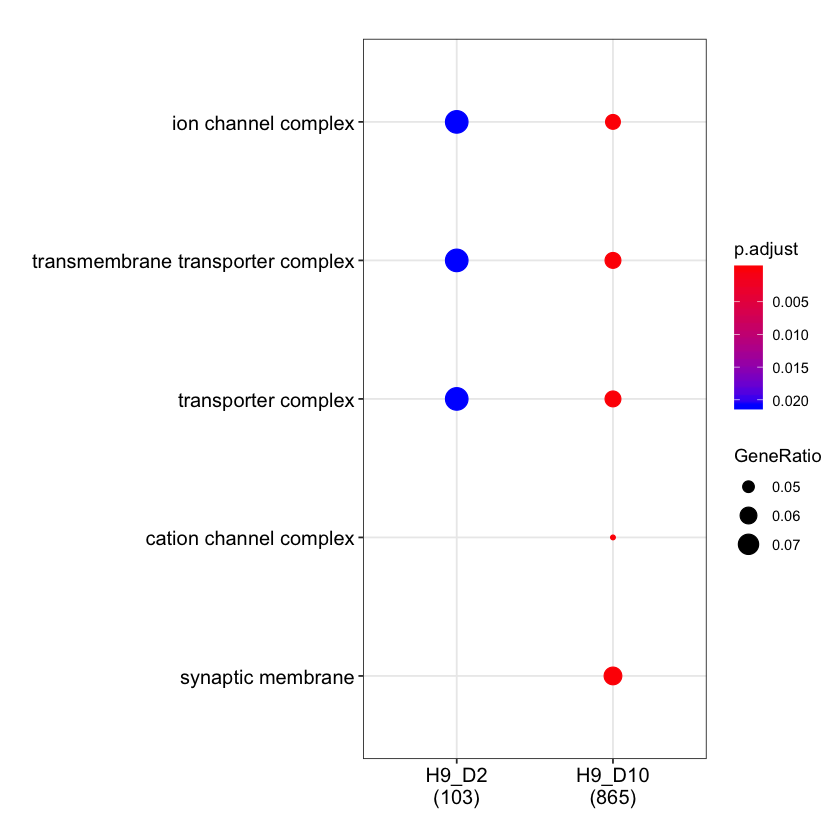

In [302]:
dotplot(ck_go_bp)
ggsave(file = paste0(save_prefix, "ck_go_bp_groups_",suffix,".png"),height=7, width=10)
dotplot(ck_go_mf)
ggsave(file = paste0(save_prefix, "ck_go_mf_groups_",suffix,".png"),height=7, width=10)
dotplot(ck_go_cc)
ggsave(file = paste0(save_prefix, "ck_go_cc_groups_",suffix,".png"),height=7, width=10)

# get tfs in each group

In [110]:

# all_genes = read.table(file = paste0(save_prefix, "all_genes.csv"))$V1

In [111]:
# tf_df = read.csv('../data/external/HOCOMOCOv11_annotation.csv',)
# tfs = as.character(tf_df$tf)

In [112]:
# SLD0_tfs = purple_genes[unique_SLD0 %in% tfs]
# SLD2_tfs = green_genes[unique_SLD2 %in% tfs]
# SLCD0_tfs = blue_genes[unique_SLCD0 %in% tfs]
# SLCD2_tfs = grey_genes[unique_SLCD2 %in% tfs]
# H9D0_tfs = grey_genes[unique_H9D0 %in% tfs]
# H9D2_tfs = grey_genes[unique_H9D2 %in% tfs]
# H9D10_tfs = grey_genes[unique_H9D10 %in% tfs]
# H9D28_tfs = grey_genes[unique_H9D28 %in% tfs]

# length(SLD0_tfs)
# length(SLD2_tfs)
# length(SLCD0_tfs)
# length(SLCD2_tfs)
# length(H9D0_tfs)
# length(H9D2_tfs)
# length(H9D10_tfs)
# length(H9D28_tfs)

ERROR: Error in eval(expr, envir, enclos): object 'purple_genes' not found
